# 簡單介紹一下什麼是主餘震序列
什麼是主餘震序列，就是當我們看到一顆規模較大的地震發生之後，接二連三有許多規模較小的地震在附近接連發生的地震序列。在這個序列當中規模最大的地震稱為主震，跟隨在主震後面發生的地震稱為餘震。讓我們以2003年12月發生的成功地震為一個例子。成功地震發生於2003年12月10日，發生斷層為池上斷層，由中央氣象所提供的地震目錄顯示，主震規模為6.4，深度為17公里。圖一(a)為2003年11月10日至2004年一月10日在台灣東南區域的地震分布圖，圖中紅色星號為主震位置，圓圈為期間內之地震位置，圓圈的顏色為與主震相對發震時間，由圖上可以看到主震後一個月的地震分佈(綠色至紅色圓圈)比主震前一個月(藍色系圓圈)的地震分佈密集。而圖一(b)為2003年11月10日至2004年一月10日之每天地震速率。可以發現地震速率在主震之後突然上升，然後地震速率漸漸回到主震之前的水準。如果我們比對主震前一個禮拜與主震後一個禮拜的地震速率，主震前一個禮拜的地震速率為1.85/day,主震後一個禮拜的地震速率為43.57/day。所以我們可以簡單計算地震前後特定時間窗口下地震速率的比值，並且設定一個門檻，只要這顆地震前後的速率比高於門檻值我就說這個地震可能屬於主餘震序列。
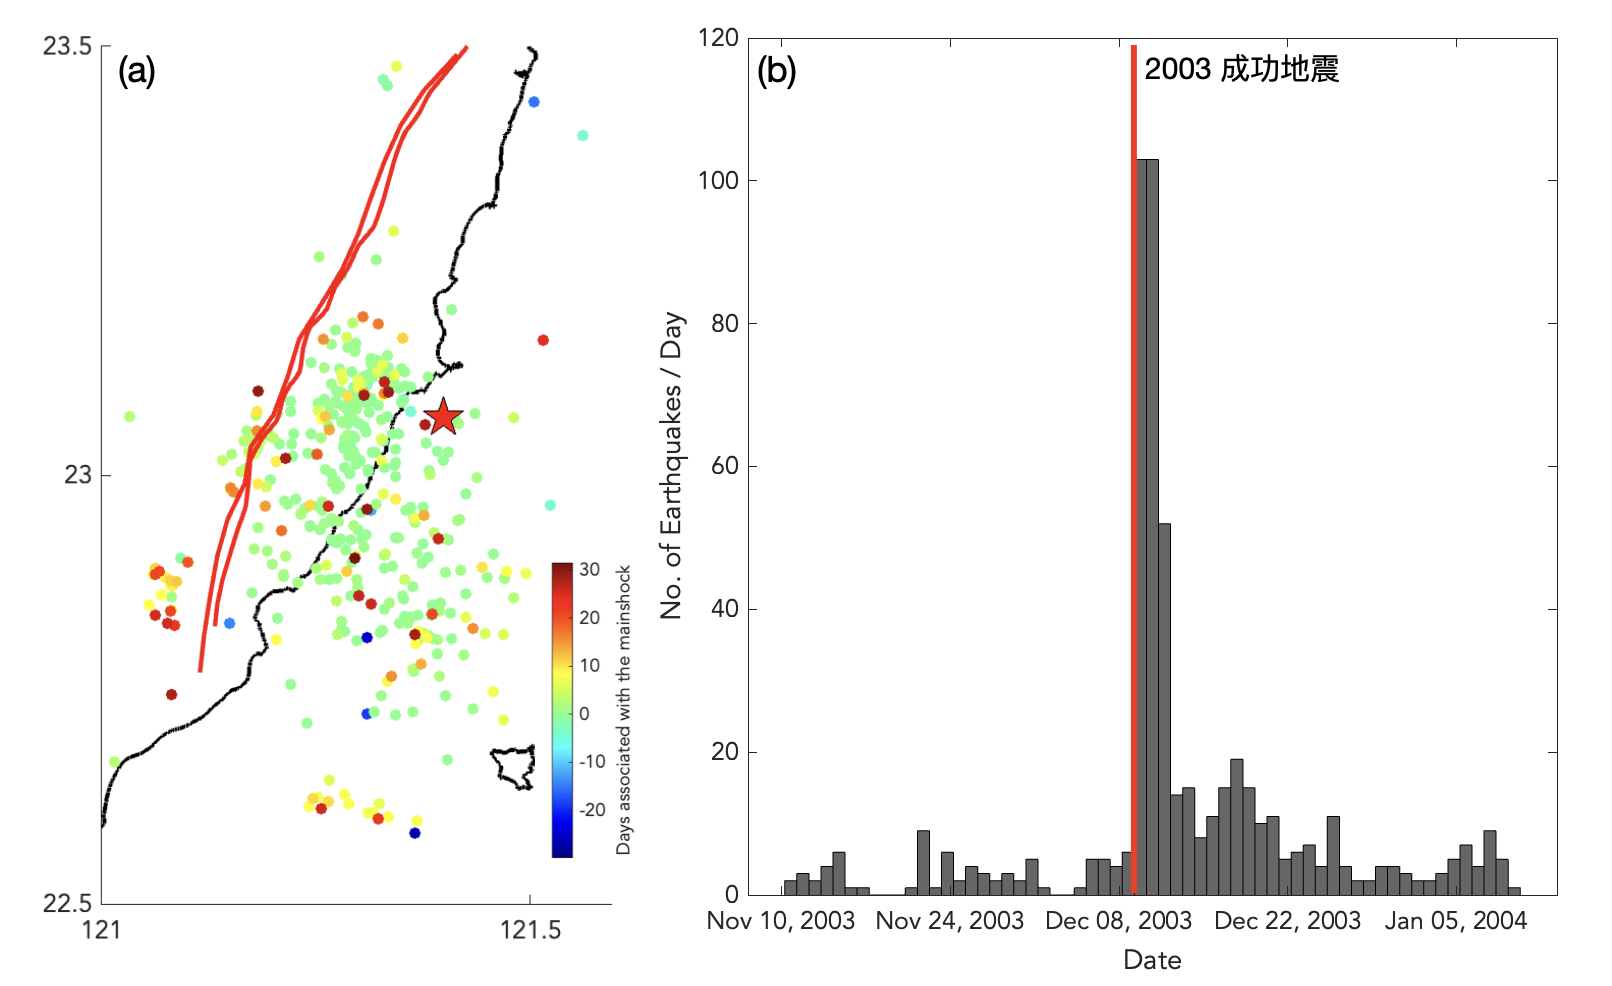

# 利用python 拿掉主餘震序列
我們的目的就是要計算地震前後的地震速率，所以我們只需要三個步驟
(1) 決定計算速率的時間窗口 t1、t2。(t1 = 地震前的時間窗口，t2 = 地震後的時間窗口)
(2) 計算在窗口內的地震數量 n1、n2。(n1 = 地震前t1窗口內的地震數量，n2 = 地震後t2窗口內的地震數量)
(3) 若 ratio = (n2/t2)/(n1/t1) 大於門檻 (thres) ，我們就說地震後t2時間窗口內的地震皆屬於主餘震序列  

好啦！讓我們來計算看看吧！

首先，我們需要呼叫幾個modolus, numpy 與 matplotlib
numpy 基本上來說是用於陣列的運算，而 matplotlib 則用於畫圖

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

接下來是要指定地震目錄的檔案，目前地震目錄的檔案叫做eq_test，你可以改成自己的檔案名稱

In [ ]:
eq_file='eq_test'

因為地震目錄檔案基本上都很大，為了節省記憶體空個，我們通常都會讀成list形式，以下的小程式 read_eq_file 就是讓程式以list格式讀取地震目錄
記得line.split()裡面用的是'\t'是因為excel存成txt檔的時候是用tab把欄位分開

In [ ]:
def read_eq_file(eq_file):
    with open(eq_file) as fp:
        for line in fp:
            parts = line.split('\t') #這邊用 '\t' 是因為你在excel存成txt檔是用tab把欄位分開
            yield parts 

有了上述的前置作業之後，我們就可以來讀地震目錄，此地震目錄包含了經度緯度時間規模深度等資料，但是我們只要用時間資料即可

In [ ]:
eq_data = read_eq_file(eq_file) #讀檔
eq_list=list(eq_data)
time_data = [row[10] for row in eq_list] #把11欄擷取起來 (11欄是地震發震時間，以年為單位)

接下來我們要定義t1,t2與thres
t1 : 地震發震前的時間長度 (ex: 30 天), t2 : 地震發震後的時間長度 (ex: 30 天)
r_thres : 地震前後速率的最小比值 (超過此比值我們判定這顆地震屬於主餘震)

In [ ]:
t1 = 3/365.25
t2 = 30/365.25
r_thres = 10

定義完之後，計算每顆地震的n1、n2與ratio，我的做法是，
(1)先計算地震兩兩時間差
(2)然後再算t1與t2時間窗口之內的地震速率
(3)計算比值
*因為python只要超過一個迴圈執行速度就會變得非常慢，所以基本上任何運段都是用List Comprehension或是generator來執行

In [ ]:
rate = []
s=(len(time_data))
# 計算地震兩兩時間差
timediff = [float(num)-float(i) for num in time_data for i in time_data] 
x = np.reshape(timediff, (s, s)).tolist()
# 計算地震前(t1內)的地震速率(eq_rate_in_t1), 地震後(t2內)的地震速率(eq_rate_in_t2) 與 其比值 t2/t1 (result)
# 並且把它寫入rate這個變數裡， rate這個變數有三欄 (eq_rate_in_t1,eq_rate_in_t2,result)
gen = [i for i in x]
for u in gen:
    eq_rate_in_t1 = len(list(filter(lambda a: 0 < a <= t1, u)))/t1
    eq_rate_in_t2 = len(list(filter(lambda a: -t2 <= a < 0, u)))/t2
    result = eq_rate_in_t1 and eq_rate_in_t2 / eq_rate_in_t1 or 0 
    rate_data = (eq_rate_in_t1, eq_rate_in_t2, result)
    rate.append(rate_data)
ratio_data = [row[2] for row in rate] # 單擷取ratio

有了每個地震的ratio之後，我們就可以擷取ratio > r_thres 的地震
然後把這些地震t2內的地震都選起來稱為主餘震序列
這個程式最後的輸出 
(1) mainshock_aftershock_inx #主餘震序列的欄位
(2) decluster_inx #非主餘震序列的欄位

In [ ]:
ratio_inx0 = [(idx, num) for idx, num in enumerate(ratio_data) if num > r_thres] #找出ratio_data裡大於r_thres的欄位
mainshock_inx = [row[0] for row in ratio_inx0] #把過門檻的欄位抓出來
mainshock = [eq_list[i] for i in mainshock_inx] #把門檻的地震抓出來 -> 主震
mainshock_t = [row[10] for row in mainshock] #把主震的時間抓出來
timediff2 = [ (num,ii) for num in mainshock_t for ii,i in enumerate(time_data) if -t2 <=(float(num)-float(i)) < 0] 
aftershock_inx = [row[1] for row in timediff2] #把每個主震的餘震欄位抓出來
mainshock_aftershock_inx_tmp = mainshock_inx + aftershock_inx 
tmp = np.array(mainshock_aftershock_inx_tmp);
mainshock_aftershock_inx = np.unique(tmp).tolist() #主餘震序列欄位
mainshock_aftershock_data = [eq_list[i] for i in mainshock_aftershock_inx] #主餘震序列
eq_inx =  list(range(0,s))
s_ma = set(mainshock_aftershock_inx)
decluster_inx = [x for x in eq_inx if x not in s_ma] #非主餘震序列欄位
decluster_data = [eq_list[i] for i in decluster_inx] #非主餘震序列
decluster_T = [row[10] for row in decluster_data]

最後，可以來畫圖！讓我們來比較把主震去掉的地震目錄隨時間變化（上圖）與原始地震目錄隨時間變化（下圖）
是不是發現有一些小小的不一樣？?

In [ ]:
fig, ax = plt.subplots(2,1);
d_T = np.array(decluster_T,dtype=float) # 先把list轉成浮點數，因為在list裡面的東西都屬於字串
ax[0].plot(d_T,range(len(decluster_T))) # 畫圖，非主餘震序列隨時間變化
d_T2 = np.array(time_data,dtype=float)
ax[1].plot(d_T2,range(len(time_data)))  # 畫圖，地震隨時間變化